# Hinged cylindrical isotropic roof

In [1]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from dolfinx import plot, default_scalar_type

from tqdm import tqdm
import pyvista

# Simulation setup

In [2]:
pyvista.start_xvfb()

In [3]:
nex = int(16)
ney = int(16)

PSRI_control = True

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2",
            5 : "qua_S2",}

ele_index = 4
ele_type = ele_dict[ele_index]


if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

elif ele_type == "qua_S2":
    cell_type = CellType.quadrilateral

In [4]:
from pathlib import Path
thickness = 12.7
if PSRI_control:
    results_folder = Path(f"results/nonlinear-naghdi/PSRI/hinged-roof/thickness-{thickness}/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear-naghdi/FI/hinged-roof/thickness-{thickness}/{nex}_{ney}_{ele_type}")

results_folder.mkdir(exist_ok=True, parents=True)

# Mesh

In [5]:
r = 2540.0
L = 254.0
rad = 0.1

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [r*rad, L]]), 
                        [nex, ney], cell_type)

tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
if ele_index == 5:
    S2 = element("Serendipity", cell, degree=2)
elif ele_index == 2:
    B3 = element("Bubble", cell, degree=3)

## Plot mesh

In [6]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
plotter.show()
plotter.close()

Widget(value='<iframe src="http://localhost:46491/index.html?ui=P_0x7f08ed4ad450_0&reconnect=auto" class="pyvi…

# Material

In [7]:
E, nu = 3102.75, 0.3 
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = Constant(mesh, default_scalar_type(thickness))

# Initial Shape

In [8]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0] / r), x[1], r * ufl.cos(x[0] / r)])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(ufl.inner(n, n))

n0_ufl = unit_normal(phi0_ufl)


def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(ufl.inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(ufl.inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## Plot initial shape

In [9]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=20)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show()
plotter.close()

Widget(value='<iframe src="http://localhost:46491/index.html?ui=P_0x7f08e30b5b90_0&reconnect=auto" class="pyvi…

# Shell element

In [10]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
elif ele_type == "qua_S2":
    naghdi_shell_element = mixed_element(
        [blocked_element(S2, shape=(3,)), blocked_element(S2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = ufl.split(q_func) # current displacement and rotation

# Shell model

In [11]:
# current deformation gradient 
F = ufl.grad(u_func) + ufl.grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = ufl.grad(phi0_ufl).T * ufl.grad(phi0_ufl)
b0_ufl = 0.5*( ufl.grad(phi0_ufl).T * ufl.grad(n0_ufl) + ufl.grad(n0_ufl).T * ufl.grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return 0.5 * (F.T * ufl.grad(d) + ufl.grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*ufl.inner(N, epsilon(F))

psi_b = 0.5*ufl.inner(M, kappa(F, d))

psi_s = 0.5*ufl.inner(T, gamma(F, d))

# Weak form Equation with PSRI

In [12]:
if ele_type == "qua_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
        
elif ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
f = Constant(mesh, default_scalar_type((0.0, 0.0, 0.0, 0.0, 0.0)))
Wext = ufl.inner(f, q_func)*dx_f

Fint = ufl.derivative(Pi_PSRI, q_func, q_test)
Fext = ufl.derivative(Wext, q_func, q_test)

Residual = Fint - Fext
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Boundary conditions

In [13]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

Q0 = naghdi_shell_FS.sub(0)
Q1 = naghdi_shell_FS.sub(1)

u_clamped = Function(u_FS) # default value is 0
theta_clamped = Function(theta_FS) # default value is 0

## Top: Symmetric $u_2 = \theta_1 = 0$

In [14]:
def top_boundary(x):
    return np.isclose(x[1], L)

top_facets = locate_entities_boundary(mesh, fdim, top_boundary)

# u2 = 0 on the top boundary
u_id = int(1)
symm_dofs_u_top = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, top_facets)
bc_u_top = dirichletbc(u_clamped, symm_dofs_u_top, Q0.sub(u_id))

# theta1 = 0 on the top boundary
theta_id = int(0)
symm_dofs_theta_top = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, top_facets)
bc_theta_top = dirichletbc(theta_clamped, symm_dofs_theta_top, Q1.sub(theta_id))

## Left: Symmetric $u_1 = \theta_2 = 0$

In [15]:
def left_boundary(x):
    return np.isclose(x[0], 0.0)

left_facets = locate_entities_boundary(mesh, fdim, left_boundary)

# u1 = 0 on the left boundary
u_id = int(0)
symm_dofs_u_left = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, left_facets)
bc_u_left = dirichletbc(u_clamped, symm_dofs_u_left, Q0.sub(u_id))

# theta2 = 0 on the left boundary
theta_id = int(1)
symm_dofs_theta_left = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, left_facets)
bc_theta_left = dirichletbc(theta_clamped, symm_dofs_theta_left, Q1.sub(theta_id))

## Right: Hinged $u_1 = u_2 = u_3 = 0$

In [16]:
def right_boundary(x):
    return np.isclose(x[0], r*rad)

right_facets = locate_entities_boundary(mesh, fdim, right_boundary)

# u1, u2, u3 = 0 on the clamped boundary
hinged_dofs_u_right = locate_dofs_topological((Q0, u_FS), fdim, right_facets)
bc_u_right = dirichletbc(u_clamped, hinged_dofs_u_right, Q0)

In [17]:
bcs = [bc_u_top, bc_theta_top, bc_u_left, bc_theta_left, bc_u_right]

# Point Source

In [18]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmap
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))
        # Strip out basis function values per cell
        basis_values = values[0]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

# Point source
if mesh.comm.rank == 0:
    ps_point_A = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    ps_point_A = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cell_A, basis_values_A = compute_cell_contributions(naghdi_shell_FS, ps_point_A)
ps_cells = [ps_cell_A]
ps_basis_values = [basis_values_A]
ps_dirs = [2]
ps_scales = [1.0]

print(f"total cells: {ps_cells}")
print(f"total basis_values: {ps_basis_values}")

total cells: [[120]]
total basis_values: [array([0., 1., 0., 0., 0., 0., 0., 0., 0.])]


# Arc length solver

In [19]:
from ArclengthProblem import ArclengthProblem

aproblem = ArclengthProblem(Fint, Fext, q_func, lmbda0= 0.0, bcs=bcs,
                              J=Jacobian, 
                              petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
                              ps_cells=ps_cells, ps_basis_values=ps_basis_values,
                              ps_dirs=ps_dirs, ps_scales=ps_scales)
aproblem.max_it = 20

In [20]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")

## Newton steps with 2nd order predictions

In [21]:
nstep = 400

Fc_list = np.zeros(nstep)

q_func.x.array[:] = 0.0

bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

aproblem.reset()
if mesh.comm.rank == 0:
    u3_list = np.zeros(nstep)

i = 0
ds_max = 0.0
pbar = tqdm(total=nstep)

while i < nstep:
    if i < 3:
        Pred = False
        Fc = -10 * i
    else:
        Pred = True
        Fc = 0.0
    
    n, converged = aproblem.NewtonStep(Pred, Fc)
        
    if converged:
        q_func.x.scatter_forward()
        Fc = aproblem.lmbda
        Fc_list[i] = Fc
        
        if not Pred:
            ds_max = max(aproblem.ds, ds_max)
        # write output
        if ele_type == "qua_P1" or ele_type == "tri_P1":
            phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
        else:
            phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
            
        if ele_type == "tri_P2B3":
            u_P2B3 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_P2B3)
            theta_sol = q_func.sub(1).collapse()
        elif ele_type == "qua_S2":
            u_S2 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_S2)
            
            theta_S2 = q_func.sub(1).collapse()
            theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
            theta_sol = Function(theta_FS)
            theta_sol.interpolate(theta_S2)
            
        else:
            u_sol = q_func.sub(0).collapse()
            theta_sol = q_func.sub(1).collapse()
        
        phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
        phi_sol = Function(phi_FS)
        phi_sol.interpolate(phi_expr)
        
        file_u.write_function(u_sol, i)
        file_theta.write_function(theta_sol, i)
        file_phi.write_function(phi_sol, i)
        
        # calculate u3 at the point load
        u3_bb = 0.0
        u3_func = q_func.sub(0).sub(2).collapse()
        if len(ps_cells) > 0:
            u3_bb = u3_func.eval(bb_point, ps_cells[0])[0]
        u3_bb = mesh.comm.allreduce(u3_bb, op=MPI.SUM)
        if mesh.comm.rank == 0:
            u3_list[i] = u3_bb
            print(f"Load step {i:d}, Number of iterations: {n:d}, " 
                f"Load: {Fc:.2f}, Disp: {u3_bb:.2f}, "
                f"ds: {aproblem.ds:.2f}, s: {aproblem.s:.2f}", flush=True)
            
        # adaptive step size control
        if n < 4:
            aproblem.ds = min(1.2*aproblem.ds, ds_max)
        if n > 6:
            aproblem.ds *= 0.8
            
        if Fc_list[i] < - 750.0:
            break
        
        i += 1
        pbar.update(1)
    else:
        aproblem.ds *= 0.5

   
file_u.close()
file_theta.close()
file_phi.close()
pbar.close()


  0%|          | 0/400 [00:00<?, ?it/s]

Load step 0, Number of iterations: 1, Load: 0.00, Disp: -0.00, ds: 0.00, s: 0.00


  0%|          | 1/400 [00:00<01:08,  5.79it/s]

Load step 1, Number of iterations: 4, Load: -10.00, Disp: -0.10, ds: 10.09, s: 10.09


  0%|          | 2/400 [00:00<02:10,  3.06it/s]

Load step 2, Number of iterations: 4, Load: -20.00, Disp: -0.21, ds: 10.09, s: 20.18


  1%|          | 3/400 [00:01<02:31,  2.62it/s]

Load step 3, Number of iterations: 2, Load: -30.00, Disp: -0.31, ds: 10.09, s: 30.27


  1%|          | 4/400 [00:01<02:11,  3.00it/s]

Load step 4, Number of iterations: 2, Load: -39.99, Disp: -0.42, ds: 10.09, s: 40.37


  1%|▏         | 5/400 [00:01<02:05,  3.14it/s]

Load step 5, Number of iterations: 2, Load: -49.99, Disp: -0.53, ds: 10.09, s: 50.46


  2%|▏         | 6/400 [00:01<01:55,  3.41it/s]

Load step 6, Number of iterations: 2, Load: -59.98, Disp: -0.63, ds: 10.09, s: 60.55


  2%|▏         | 7/400 [00:02<01:48,  3.62it/s]

Load step 7, Number of iterations: 2, Load: -69.96, Disp: -0.74, ds: 10.09, s: 70.64


  2%|▏         | 8/400 [00:02<01:44,  3.75it/s]

Load step 8, Number of iterations: 2, Load: -79.95, Disp: -0.85, ds: 10.09, s: 80.74


  2%|▏         | 9/400 [00:02<01:43,  3.77it/s]

Load step 9, Number of iterations: 2, Load: -89.93, Disp: -0.97, ds: 10.09, s: 90.83


  2%|▎         | 10/400 [00:02<01:40,  3.88it/s]

Load step 10, Number of iterations: 2, Load: -99.91, Disp: -1.08, ds: 10.09, s: 100.92


  3%|▎         | 11/400 [00:03<01:38,  3.96it/s]

Load step 11, Number of iterations: 2, Load: -109.89, Disp: -1.19, ds: 10.09, s: 111.01


  3%|▎         | 12/400 [00:03<01:46,  3.64it/s]

Load step 12, Number of iterations: 2, Load: -119.86, Disp: -1.31, ds: 10.09, s: 121.11


  3%|▎         | 13/400 [00:03<01:47,  3.61it/s]

Load step 13, Number of iterations: 2, Load: -129.83, Disp: -1.43, ds: 10.09, s: 131.20


  4%|▎         | 14/400 [00:03<01:43,  3.73it/s]

Load step 14, Number of iterations: 2, Load: -139.79, Disp: -1.55, ds: 10.09, s: 141.29


  4%|▍         | 15/400 [00:04<01:42,  3.77it/s]

Load step 15, Number of iterations: 2, Load: -149.75, Disp: -1.66, ds: 10.09, s: 151.38


  4%|▍         | 16/400 [00:04<01:39,  3.87it/s]

Load step 16, Number of iterations: 2, Load: -159.71, Disp: -1.79, ds: 10.09, s: 161.48


  4%|▍         | 17/400 [00:04<01:36,  3.96it/s]

Load step 17, Number of iterations: 2, Load: -169.66, Disp: -1.91, ds: 10.09, s: 171.57


  4%|▍         | 18/400 [00:04<01:36,  3.95it/s]

Load step 18, Number of iterations: 2, Load: -179.61, Disp: -2.03, ds: 10.09, s: 181.66


  5%|▍         | 19/400 [00:05<01:41,  3.75it/s]

Load step 19, Number of iterations: 2, Load: -189.55, Disp: -2.16, ds: 10.09, s: 191.76


  5%|▌         | 20/400 [00:05<01:38,  3.85it/s]

Load step 20, Number of iterations: 2, Load: -199.49, Disp: -2.29, ds: 10.09, s: 201.85


  5%|▌         | 21/400 [00:05<01:36,  3.92it/s]

Load step 21, Number of iterations: 2, Load: -209.42, Disp: -2.42, ds: 10.09, s: 211.94


  6%|▌         | 22/400 [00:05<01:34,  3.98it/s]

Load step 22, Number of iterations: 3, Load: -219.35, Disp: -2.55, ds: 10.09, s: 222.03


  6%|▌         | 23/400 [00:06<01:43,  3.65it/s]

Load step 23, Number of iterations: 3, Load: -229.27, Disp: -2.68, ds: 10.09, s: 232.13


  6%|▌         | 24/400 [00:06<01:52,  3.33it/s]

Load step 24, Number of iterations: 3, Load: -239.19, Disp: -2.81, ds: 10.09, s: 242.22


  6%|▋         | 25/400 [00:07<01:59,  3.13it/s]

Load step 25, Number of iterations: 3, Load: -249.09, Disp: -2.95, ds: 10.09, s: 252.31


  6%|▋         | 26/400 [00:07<02:00,  3.11it/s]

Load step 26, Number of iterations: 3, Load: -258.99, Disp: -3.09, ds: 10.09, s: 262.40


  7%|▋         | 27/400 [00:07<02:02,  3.04it/s]

Load step 27, Number of iterations: 3, Load: -268.89, Disp: -3.23, ds: 10.09, s: 272.50


  7%|▋         | 28/400 [00:08<02:04,  2.98it/s]

Load step 28, Number of iterations: 3, Load: -278.77, Disp: -3.38, ds: 10.09, s: 282.59


  7%|▋         | 29/400 [00:08<02:03,  3.01it/s]

Load step 29, Number of iterations: 3, Load: -288.64, Disp: -3.52, ds: 10.09, s: 292.68


  8%|▊         | 30/400 [00:08<02:03,  3.00it/s]

Load step 30, Number of iterations: 3, Load: -298.51, Disp: -3.67, ds: 10.09, s: 302.78


  8%|▊         | 31/400 [00:09<02:05,  2.95it/s]

Load step 31, Number of iterations: 3, Load: -308.36, Disp: -3.82, ds: 10.09, s: 312.87


  8%|▊         | 32/400 [00:09<02:10,  2.82it/s]

Load step 32, Number of iterations: 3, Load: -318.21, Disp: -3.97, ds: 10.09, s: 322.96


  8%|▊         | 33/400 [00:09<02:08,  2.85it/s]

Load step 33, Number of iterations: 3, Load: -328.04, Disp: -4.13, ds: 10.09, s: 333.06


  8%|▊         | 34/400 [00:10<02:05,  2.91it/s]

Load step 34, Number of iterations: 3, Load: -337.85, Disp: -4.29, ds: 10.09, s: 343.15


  9%|▉         | 35/400 [00:10<02:04,  2.92it/s]

Load step 35, Number of iterations: 3, Load: -347.66, Disp: -4.45, ds: 10.09, s: 353.24


  9%|▉         | 36/400 [00:10<02:02,  2.97it/s]

Load step 36, Number of iterations: 3, Load: -357.44, Disp: -4.62, ds: 10.09, s: 363.34


  9%|▉         | 37/400 [00:11<02:02,  2.95it/s]

Load step 37, Number of iterations: 3, Load: -367.21, Disp: -4.79, ds: 10.09, s: 373.43


 10%|▉         | 38/400 [00:11<02:02,  2.95it/s]

Load step 38, Number of iterations: 3, Load: -376.96, Disp: -4.96, ds: 10.09, s: 383.52


 10%|▉         | 39/400 [00:11<02:09,  2.79it/s]

Load step 39, Number of iterations: 3, Load: -386.69, Disp: -5.14, ds: 10.09, s: 393.62


 10%|█         | 40/400 [00:12<02:06,  2.84it/s]

Load step 40, Number of iterations: 3, Load: -396.40, Disp: -5.32, ds: 10.09, s: 403.71


 10%|█         | 41/400 [00:12<02:04,  2.89it/s]

Load step 41, Number of iterations: 3, Load: -406.07, Disp: -5.51, ds: 10.09, s: 413.81


 10%|█         | 42/400 [00:12<02:04,  2.89it/s]

Load step 42, Number of iterations: 3, Load: -415.72, Disp: -5.70, ds: 10.09, s: 423.91


 11%|█         | 43/400 [00:13<02:04,  2.87it/s]

Load step 43, Number of iterations: 3, Load: -425.33, Disp: -5.90, ds: 10.09, s: 434.00


 11%|█         | 44/400 [00:13<02:01,  2.92it/s]

Load step 44, Number of iterations: 3, Load: -434.91, Disp: -6.10, ds: 10.09, s: 444.10


 11%|█▏        | 45/400 [00:13<02:02,  2.90it/s]

Load step 45, Number of iterations: 3, Load: -444.44, Disp: -6.31, ds: 10.09, s: 454.20


 12%|█▏        | 46/400 [00:14<02:01,  2.92it/s]

Load step 46, Number of iterations: 3, Load: -453.92, Disp: -6.53, ds: 10.09, s: 464.30


 12%|█▏        | 47/400 [00:14<01:59,  2.95it/s]

Load step 47, Number of iterations: 3, Load: -463.34, Disp: -6.75, ds: 10.09, s: 474.40


 12%|█▏        | 48/400 [00:14<02:02,  2.88it/s]

Load step 48, Number of iterations: 3, Load: -472.68, Disp: -6.98, ds: 10.09, s: 484.51


 12%|█▏        | 49/400 [00:15<02:05,  2.79it/s]

Load step 49, Number of iterations: 3, Load: -481.94, Disp: -7.23, ds: 10.09, s: 494.62


 12%|█▎        | 50/400 [00:15<02:06,  2.76it/s]

Load step 50, Number of iterations: 3, Load: -491.10, Disp: -7.48, ds: 10.09, s: 504.73


 13%|█▎        | 51/400 [00:16<02:07,  2.74it/s]

Load step 51, Number of iterations: 3, Load: -500.13, Disp: -7.75, ds: 10.09, s: 514.85


 13%|█▎        | 52/400 [00:16<02:05,  2.78it/s]

Load step 52, Number of iterations: 3, Load: -508.99, Disp: -8.03, ds: 10.09, s: 524.99


 13%|█▎        | 53/400 [00:16<02:03,  2.81it/s]

Load step 53, Number of iterations: 3, Load: -517.64, Disp: -8.33, ds: 10.09, s: 535.15


 14%|█▎        | 54/400 [00:17<02:01,  2.85it/s]

Load step 54, Number of iterations: 3, Load: -526.01, Disp: -8.65, ds: 10.09, s: 545.34


 14%|█▍        | 55/400 [00:17<01:58,  2.90it/s]

Load step 55, Number of iterations: 3, Load: -533.98, Disp: -9.00, ds: 10.09, s: 555.60


 14%|█▍        | 56/400 [00:17<02:02,  2.81it/s]

Load step 56, Number of iterations: 4, Load: -541.40, Disp: -9.39, ds: 10.09, s: 565.99


 14%|█▍        | 57/400 [00:18<02:08,  2.67it/s]

Load step 57, Number of iterations: 4, Load: -547.95, Disp: -9.82, ds: 10.09, s: 576.69


 14%|█▍        | 58/400 [00:18<02:13,  2.55it/s]

Load step 58, Number of iterations: 4, Load: -553.13, Disp: -10.34, ds: 10.09, s: 588.38


 15%|█▍        | 59/400 [00:19<02:18,  2.47it/s]

Load step 59, Number of iterations: 5, Load: -554.73, Disp: -10.64, ds: 5.05, s: 594.83


 15%|█▌        | 60/400 [00:21<05:34,  1.02it/s]

Load step 60, Number of iterations: 4, Load: -555.11, Disp: -10.77, ds: 2.52, s: 597.84


 15%|█▌        | 61/400 [00:23<07:52,  1.39s/it]

Load step 61, Number of iterations: 4, Load: -555.20, Disp: -10.84, ds: 1.26, s: 599.15


 16%|█▌        | 62/400 [00:26<09:19,  1.65s/it]

Load step 62, Number of iterations: 4, Load: -555.25, Disp: -10.89, ds: 1.26, s: 600.43


 16%|█▌        | 63/400 [00:26<07:15,  1.29s/it]

Load step 63, Number of iterations: 3, Load: -555.24, Disp: -10.95, ds: 1.26, s: 601.70


 16%|█▌        | 64/400 [00:26<05:46,  1.03s/it]

Load step 64, Number of iterations: 3, Load: -555.19, Disp: -11.02, ds: 1.51, s: 603.22


 16%|█▋        | 65/400 [00:27<04:39,  1.20it/s]

Load step 65, Number of iterations: 3, Load: -555.04, Disp: -11.10, ds: 1.82, s: 605.05


 16%|█▋        | 66/400 [00:27<03:52,  1.44it/s]

Load step 66, Number of iterations: 3, Load: -554.75, Disp: -11.20, ds: 2.18, s: 607.24


 17%|█▋        | 67/400 [00:28<03:16,  1.69it/s]

Load step 67, Number of iterations: 3, Load: -554.24, Disp: -11.31, ds: 2.62, s: 609.89


 17%|█▋        | 68/400 [00:28<02:52,  1.93it/s]

Load step 68, Number of iterations: 3, Load: -553.41, Disp: -11.45, ds: 3.14, s: 613.08


 17%|█▋        | 69/400 [00:28<02:34,  2.15it/s]

Load step 69, Number of iterations: 3, Load: -552.13, Disp: -11.60, ds: 3.77, s: 616.92


 18%|█▊        | 70/400 [00:29<02:23,  2.31it/s]

Load step 70, Number of iterations: 3, Load: -550.22, Disp: -11.78, ds: 4.52, s: 621.55


 18%|█▊        | 71/400 [00:29<02:17,  2.38it/s]

Load step 71, Number of iterations: 3, Load: -547.49, Disp: -11.98, ds: 5.42, s: 627.12


 18%|█▊        | 72/400 [00:29<02:10,  2.51it/s]

Load step 72, Number of iterations: 3, Load: -543.70, Disp: -12.20, ds: 6.51, s: 633.84


 18%|█▊        | 73/400 [00:30<02:05,  2.61it/s]

Load step 73, Number of iterations: 3, Load: -538.60, Disp: -12.44, ds: 7.81, s: 641.89


 18%|█▊        | 74/400 [00:30<02:03,  2.65it/s]

Load step 74, Number of iterations: 3, Load: -531.90, Disp: -12.70, ds: 9.37, s: 651.55


 19%|█▉        | 75/400 [00:30<02:00,  2.70it/s]

Load step 75, Number of iterations: 3, Load: -524.21, Disp: -12.95, ds: 10.09, s: 661.89


 19%|█▉        | 76/400 [00:31<01:58,  2.74it/s]

Load step 76, Number of iterations: 3, Load: -516.21, Disp: -13.17, ds: 10.09, s: 672.16


 19%|█▉        | 77/400 [00:31<01:57,  2.76it/s]

Load step 77, Number of iterations: 3, Load: -507.98, Disp: -13.37, ds: 10.09, s: 682.37


 20%|█▉        | 78/400 [00:31<01:58,  2.72it/s]

Load step 78, Number of iterations: 3, Load: -499.58, Disp: -13.56, ds: 10.09, s: 692.53


 20%|█▉        | 79/400 [00:32<01:59,  2.69it/s]

Load step 79, Number of iterations: 3, Load: -491.03, Disp: -13.73, ds: 10.09, s: 702.68


 20%|██        | 80/400 [00:32<01:54,  2.79it/s]

Load step 80, Number of iterations: 3, Load: -482.36, Disp: -13.89, ds: 10.09, s: 712.81


 20%|██        | 81/400 [00:33<01:56,  2.74it/s]

Load step 81, Number of iterations: 3, Load: -473.60, Disp: -14.04, ds: 10.09, s: 722.93


 20%|██        | 82/400 [00:33<01:53,  2.80it/s]

Load step 82, Number of iterations: 3, Load: -464.76, Disp: -14.18, ds: 10.09, s: 733.04


 21%|██        | 83/400 [00:33<01:56,  2.73it/s]

Load step 83, Number of iterations: 3, Load: -455.85, Disp: -14.31, ds: 10.09, s: 743.15


 21%|██        | 84/400 [00:34<01:52,  2.81it/s]

Load step 84, Number of iterations: 3, Load: -446.88, Disp: -14.43, ds: 10.09, s: 753.25


 21%|██▏       | 85/400 [00:34<01:52,  2.80it/s]

Load step 85, Number of iterations: 3, Load: -437.86, Disp: -14.55, ds: 10.09, s: 763.36


 22%|██▏       | 86/400 [00:34<01:50,  2.85it/s]

Load step 86, Number of iterations: 3, Load: -428.80, Disp: -14.67, ds: 10.09, s: 773.46


 22%|██▏       | 87/400 [00:35<01:48,  2.88it/s]

Load step 87, Number of iterations: 3, Load: -419.71, Disp: -14.78, ds: 10.09, s: 783.56


 22%|██▏       | 88/400 [00:35<01:47,  2.91it/s]

Load step 88, Number of iterations: 3, Load: -410.58, Disp: -14.88, ds: 10.09, s: 793.66


 22%|██▏       | 89/400 [00:35<01:45,  2.94it/s]

Load step 89, Number of iterations: 3, Load: -401.43, Disp: -14.99, ds: 10.09, s: 803.75


 22%|██▎       | 90/400 [00:36<01:48,  2.85it/s]

Load step 90, Number of iterations: 3, Load: -392.26, Disp: -15.09, ds: 10.09, s: 813.85


 23%|██▎       | 91/400 [00:36<01:49,  2.82it/s]

Load step 91, Number of iterations: 3, Load: -383.07, Disp: -15.18, ds: 10.09, s: 823.95


 23%|██▎       | 92/400 [00:36<01:48,  2.83it/s]

Load step 92, Number of iterations: 3, Load: -373.86, Disp: -15.28, ds: 10.09, s: 834.04


 23%|██▎       | 93/400 [00:37<01:48,  2.83it/s]

Load step 93, Number of iterations: 3, Load: -364.65, Disp: -15.37, ds: 10.09, s: 844.14


 24%|██▎       | 94/400 [00:37<01:47,  2.85it/s]

Load step 94, Number of iterations: 3, Load: -355.42, Disp: -15.46, ds: 10.09, s: 854.23


 24%|██▍       | 95/400 [00:37<01:46,  2.87it/s]

Load step 95, Number of iterations: 3, Load: -346.19, Disp: -15.55, ds: 10.09, s: 864.33


 24%|██▍       | 96/400 [00:38<01:44,  2.91it/s]

Load step 96, Number of iterations: 3, Load: -336.95, Disp: -15.64, ds: 10.09, s: 874.42


 24%|██▍       | 97/400 [00:38<01:49,  2.76it/s]

Load step 97, Number of iterations: 3, Load: -327.71, Disp: -15.73, ds: 10.09, s: 884.52


 24%|██▍       | 98/400 [00:39<01:47,  2.81it/s]

Load step 98, Number of iterations: 3, Load: -318.47, Disp: -15.82, ds: 10.09, s: 894.61


 25%|██▍       | 99/400 [00:39<01:44,  2.87it/s]

Load step 99, Number of iterations: 3, Load: -309.24, Disp: -15.91, ds: 10.09, s: 904.71


 25%|██▌       | 100/400 [00:39<01:51,  2.70it/s]

Load step 100, Number of iterations: 3, Load: -300.01, Disp: -15.99, ds: 10.09, s: 914.81


 25%|██▌       | 101/400 [00:40<01:56,  2.57it/s]

Load step 101, Number of iterations: 3, Load: -290.79, Disp: -16.08, ds: 10.09, s: 924.90


 26%|██▌       | 102/400 [00:40<01:53,  2.63it/s]

Load step 102, Number of iterations: 3, Load: -281.59, Disp: -16.17, ds: 10.09, s: 935.00


 26%|██▌       | 103/400 [00:40<01:51,  2.66it/s]

Load step 103, Number of iterations: 3, Load: -272.40, Disp: -16.27, ds: 10.09, s: 945.09


 26%|██▌       | 104/400 [00:41<01:53,  2.61it/s]

Load step 104, Number of iterations: 3, Load: -263.23, Disp: -16.36, ds: 10.09, s: 955.19


 26%|██▋       | 105/400 [00:41<01:48,  2.72it/s]

Load step 105, Number of iterations: 3, Load: -254.08, Disp: -16.46, ds: 10.09, s: 965.29


 26%|██▋       | 106/400 [00:41<01:44,  2.80it/s]

Load step 106, Number of iterations: 3, Load: -244.96, Disp: -16.55, ds: 10.09, s: 975.38


 27%|██▋       | 107/400 [00:42<01:41,  2.88it/s]

Load step 107, Number of iterations: 3, Load: -235.88, Disp: -16.66, ds: 10.09, s: 985.48


 27%|██▋       | 108/400 [00:42<01:39,  2.93it/s]

Load step 108, Number of iterations: 3, Load: -226.83, Disp: -16.76, ds: 10.09, s: 995.58


 27%|██▋       | 109/400 [00:43<01:41,  2.87it/s]

Load step 109, Number of iterations: 3, Load: -217.83, Disp: -16.87, ds: 10.09, s: 1005.68


 28%|██▊       | 110/400 [00:43<01:39,  2.91it/s]

Load step 110, Number of iterations: 3, Load: -208.89, Disp: -16.99, ds: 10.09, s: 1015.79


 28%|██▊       | 111/400 [00:43<01:42,  2.83it/s]

Load step 111, Number of iterations: 3, Load: -200.02, Disp: -17.11, ds: 10.09, s: 1025.89


 28%|██▊       | 112/400 [00:44<01:39,  2.89it/s]

Load step 112, Number of iterations: 3, Load: -191.23, Disp: -17.25, ds: 10.09, s: 1036.01


 28%|██▊       | 113/400 [00:44<01:38,  2.91it/s]

Load step 113, Number of iterations: 3, Load: -182.55, Disp: -17.39, ds: 10.09, s: 1046.12


 28%|██▊       | 114/400 [00:44<01:37,  2.92it/s]

Load step 114, Number of iterations: 3, Load: -174.01, Disp: -17.54, ds: 10.09, s: 1056.25


 29%|██▉       | 115/400 [00:45<01:40,  2.85it/s]

Load step 115, Number of iterations: 3, Load: -165.63, Disp: -17.70, ds: 10.09, s: 1066.39


 29%|██▉       | 116/400 [00:45<01:38,  2.88it/s]

Load step 116, Number of iterations: 3, Load: -157.47, Disp: -17.89, ds: 10.09, s: 1076.56


 29%|██▉       | 117/400 [00:45<01:39,  2.84it/s]

Load step 117, Number of iterations: 3, Load: -149.62, Disp: -18.09, ds: 10.09, s: 1086.78


 30%|██▉       | 118/400 [00:46<01:42,  2.76it/s]

Load step 118, Number of iterations: 3, Load: -142.20, Disp: -18.32, ds: 10.09, s: 1097.09


 30%|██▉       | 119/400 [00:46<01:38,  2.84it/s]

Load step 119, Number of iterations: 4, Load: -135.42, Disp: -18.60, ds: 10.09, s: 1107.62


 30%|███       | 120/400 [00:46<01:45,  2.65it/s]

Load step 120, Number of iterations: 4, Load: -129.70, Disp: -18.96, ds: 10.09, s: 1118.85


 30%|███       | 121/400 [00:47<01:49,  2.56it/s]

Load step 121, Number of iterations: 4, Load: -127.63, Disp: -19.17, ds: 5.05, s: 1124.90


 30%|███       | 122/400 [00:49<04:18,  1.08it/s]

Load step 122, Number of iterations: 7, Load: -126.44, Disp: -19.49, ds: 5.05, s: 1132.94


 31%|███       | 123/400 [00:50<03:57,  1.17it/s]

Load step 123, Number of iterations: 5, Load: -126.52, Disp: -19.61, ds: 4.04, s: 1135.77


 31%|███       | 124/400 [00:50<03:30,  1.31it/s]

Load step 124, Number of iterations: 4, Load: -127.08, Disp: -19.77, ds: 4.04, s: 1139.74


 31%|███▏      | 125/400 [00:51<03:01,  1.51it/s]

Load step 125, Number of iterations: 3, Load: -128.20, Disp: -19.94, ds: 4.04, s: 1143.85


 32%|███▏      | 126/400 [00:51<02:35,  1.76it/s]

Load step 126, Number of iterations: 3, Load: -130.20, Disp: -20.14, ds: 4.84, s: 1148.87


 32%|███▏      | 127/400 [00:51<02:15,  2.01it/s]

Load step 127, Number of iterations: 4, Load: -133.40, Disp: -20.37, ds: 5.81, s: 1154.97


 32%|███▏      | 128/400 [00:52<02:08,  2.11it/s]

Load step 128, Number of iterations: 4, Load: -137.23, Disp: -20.59, ds: 5.81, s: 1161.08


 32%|███▏      | 129/400 [00:52<02:03,  2.19it/s]

Load step 129, Number of iterations: 4, Load: -141.46, Disp: -20.80, ds: 5.81, s: 1167.12


 32%|███▎      | 130/400 [00:53<02:01,  2.22it/s]

Load step 130, Number of iterations: 3, Load: -145.95, Disp: -20.98, ds: 5.81, s: 1173.08


 33%|███▎      | 131/400 [00:53<01:55,  2.33it/s]

Load step 131, Number of iterations: 3, Load: -151.61, Disp: -21.19, ds: 6.98, s: 1180.18


 33%|███▎      | 132/400 [00:53<01:48,  2.46it/s]

Load step 132, Number of iterations: 3, Load: -158.70, Disp: -21.43, ds: 8.37, s: 1188.69


 33%|███▎      | 133/400 [00:54<01:42,  2.60it/s]

Load step 133, Number of iterations: 3, Load: -167.50, Disp: -21.69, ds: 10.05, s: 1198.88


 34%|███▎      | 134/400 [00:54<01:40,  2.64it/s]

Load step 134, Number of iterations: 3, Load: -176.57, Disp: -21.93, ds: 10.09, s: 1209.08


 34%|███▍      | 135/400 [00:54<01:36,  2.74it/s]

Load step 135, Number of iterations: 3, Load: -185.78, Disp: -22.16, ds: 10.09, s: 1219.25


 34%|███▍      | 136/400 [00:55<01:35,  2.76it/s]

Load step 136, Number of iterations: 3, Load: -195.10, Disp: -22.37, ds: 10.09, s: 1229.38


 34%|███▍      | 137/400 [00:55<01:33,  2.81it/s]

Load step 137, Number of iterations: 3, Load: -204.51, Disp: -22.58, ds: 10.09, s: 1239.51


 34%|███▍      | 138/400 [00:55<01:34,  2.77it/s]

Load step 138, Number of iterations: 3, Load: -214.00, Disp: -22.77, ds: 10.09, s: 1249.62


 35%|███▍      | 139/400 [00:56<01:32,  2.81it/s]

Load step 139, Number of iterations: 3, Load: -223.54, Disp: -22.96, ds: 10.09, s: 1259.73


 35%|███▌      | 140/400 [00:56<01:31,  2.86it/s]

Load step 140, Number of iterations: 3, Load: -233.14, Disp: -23.14, ds: 10.09, s: 1269.84


 35%|███▌      | 141/400 [00:57<01:29,  2.90it/s]

Load step 141, Number of iterations: 3, Load: -242.77, Disp: -23.31, ds: 10.09, s: 1279.94


 36%|███▌      | 142/400 [00:57<01:28,  2.90it/s]

Load step 142, Number of iterations: 3, Load: -252.45, Disp: -23.48, ds: 10.09, s: 1290.04


 36%|███▌      | 143/400 [00:57<01:27,  2.93it/s]

Load step 143, Number of iterations: 3, Load: -262.16, Disp: -23.64, ds: 10.09, s: 1300.14


 36%|███▌      | 144/400 [00:58<01:26,  2.94it/s]

Load step 144, Number of iterations: 3, Load: -271.89, Disp: -23.80, ds: 10.09, s: 1310.23


 36%|███▋      | 145/400 [00:58<01:28,  2.87it/s]

Load step 145, Number of iterations: 3, Load: -281.65, Disp: -23.95, ds: 10.09, s: 1320.33


 36%|███▋      | 146/400 [00:58<01:27,  2.90it/s]

Load step 146, Number of iterations: 3, Load: -291.44, Disp: -24.10, ds: 10.09, s: 1330.42


 37%|███▋      | 147/400 [00:59<01:26,  2.93it/s]

Load step 147, Number of iterations: 3, Load: -301.24, Disp: -24.25, ds: 10.09, s: 1340.52


 37%|███▋      | 148/400 [00:59<01:28,  2.84it/s]

Load step 148, Number of iterations: 3, Load: -311.06, Disp: -24.39, ds: 10.09, s: 1350.61


 37%|███▋      | 149/400 [00:59<01:27,  2.88it/s]

Load step 149, Number of iterations: 3, Load: -320.89, Disp: -24.53, ds: 10.09, s: 1360.71


 38%|███▊      | 150/400 [01:00<01:26,  2.88it/s]

Load step 150, Number of iterations: 3, Load: -330.74, Disp: -24.66, ds: 10.09, s: 1370.80


 38%|███▊      | 151/400 [01:00<01:27,  2.85it/s]

Load step 151, Number of iterations: 3, Load: -340.60, Disp: -24.80, ds: 10.09, s: 1380.90


 38%|███▊      | 152/400 [01:00<01:29,  2.78it/s]

Load step 152, Number of iterations: 3, Load: -350.47, Disp: -24.93, ds: 10.09, s: 1390.99


 38%|███▊      | 153/400 [01:01<01:27,  2.81it/s]

Load step 153, Number of iterations: 3, Load: -360.36, Disp: -25.05, ds: 10.09, s: 1401.08


 38%|███▊      | 154/400 [01:01<01:25,  2.87it/s]

Load step 154, Number of iterations: 3, Load: -370.25, Disp: -25.18, ds: 10.09, s: 1411.18


 39%|███▉      | 155/400 [01:01<01:24,  2.90it/s]

Load step 155, Number of iterations: 3, Load: -380.15, Disp: -25.30, ds: 10.09, s: 1421.27


 39%|███▉      | 156/400 [01:02<01:23,  2.93it/s]

Load step 156, Number of iterations: 3, Load: -390.06, Disp: -25.42, ds: 10.09, s: 1431.36


 39%|███▉      | 157/400 [01:02<01:23,  2.91it/s]

Load step 157, Number of iterations: 3, Load: -399.98, Disp: -25.54, ds: 10.09, s: 1441.45


 40%|███▉      | 158/400 [01:02<01:22,  2.93it/s]

Load step 158, Number of iterations: 3, Load: -409.91, Disp: -25.66, ds: 10.09, s: 1451.55


 40%|███▉      | 159/400 [01:03<01:24,  2.84it/s]

Load step 159, Number of iterations: 3, Load: -419.84, Disp: -25.78, ds: 10.09, s: 1461.64


 40%|████      | 160/400 [01:03<01:23,  2.87it/s]

Load step 160, Number of iterations: 3, Load: -429.77, Disp: -25.89, ds: 10.09, s: 1471.73


 40%|████      | 161/400 [01:03<01:22,  2.90it/s]

Load step 161, Number of iterations: 3, Load: -439.72, Disp: -26.00, ds: 10.09, s: 1481.83


 40%|████      | 162/400 [01:04<01:22,  2.87it/s]

Load step 162, Number of iterations: 3, Load: -449.67, Disp: -26.11, ds: 10.09, s: 1491.92


 41%|████      | 163/400 [01:04<01:21,  2.91it/s]

Load step 163, Number of iterations: 3, Load: -459.62, Disp: -26.22, ds: 10.09, s: 1502.01


 41%|████      | 164/400 [01:04<01:22,  2.87it/s]

Load step 164, Number of iterations: 3, Load: -469.58, Disp: -26.33, ds: 10.09, s: 1512.10


 41%|████▏     | 165/400 [01:05<01:21,  2.88it/s]

Load step 165, Number of iterations: 3, Load: -479.54, Disp: -26.44, ds: 10.09, s: 1522.20


 42%|████▏     | 166/400 [01:05<01:23,  2.80it/s]

Load step 166, Number of iterations: 2, Load: -489.51, Disp: -26.54, ds: 10.09, s: 1532.29


 42%|████▏     | 167/400 [01:05<01:15,  3.09it/s]

Load step 167, Number of iterations: 2, Load: -499.48, Disp: -26.65, ds: 10.09, s: 1542.38


 42%|████▏     | 168/400 [01:06<01:09,  3.33it/s]

Load step 168, Number of iterations: 2, Load: -509.46, Disp: -26.75, ds: 10.09, s: 1552.47


 42%|████▏     | 169/400 [01:06<01:05,  3.52it/s]

Load step 169, Number of iterations: 2, Load: -519.44, Disp: -26.85, ds: 10.09, s: 1562.57


 42%|████▎     | 170/400 [01:06<01:02,  3.65it/s]

Load step 170, Number of iterations: 2, Load: -529.42, Disp: -26.95, ds: 10.09, s: 1572.66


 43%|████▎     | 171/400 [01:06<01:00,  3.76it/s]

Load step 171, Number of iterations: 2, Load: -539.41, Disp: -27.05, ds: 10.09, s: 1582.75


 43%|████▎     | 172/400 [01:07<00:59,  3.84it/s]

Load step 172, Number of iterations: 2, Load: -549.39, Disp: -27.15, ds: 10.09, s: 1592.84


 43%|████▎     | 173/400 [01:07<01:01,  3.68it/s]

Load step 173, Number of iterations: 2, Load: -559.39, Disp: -27.24, ds: 10.09, s: 1602.94


 44%|████▎     | 174/400 [01:07<00:59,  3.78it/s]

Load step 174, Number of iterations: 2, Load: -569.38, Disp: -27.34, ds: 10.09, s: 1613.03


 44%|████▍     | 175/400 [01:07<00:58,  3.85it/s]

Load step 175, Number of iterations: 2, Load: -579.38, Disp: -27.43, ds: 10.09, s: 1623.12


 44%|████▍     | 176/400 [01:08<00:58,  3.85it/s]

Load step 176, Number of iterations: 2, Load: -589.38, Disp: -27.53, ds: 10.09, s: 1633.21


 44%|████▍     | 177/400 [01:08<00:58,  3.79it/s]

Load step 177, Number of iterations: 2, Load: -599.38, Disp: -27.62, ds: 10.09, s: 1643.31


 44%|████▍     | 178/400 [01:08<00:58,  3.81it/s]

Load step 178, Number of iterations: 2, Load: -609.38, Disp: -27.71, ds: 10.09, s: 1653.40


 45%|████▍     | 179/400 [01:09<00:57,  3.87it/s]

Load step 179, Number of iterations: 2, Load: -619.39, Disp: -27.80, ds: 10.09, s: 1663.49


 45%|████▌     | 180/400 [01:09<01:00,  3.62it/s]

Load step 180, Number of iterations: 2, Load: -629.40, Disp: -27.89, ds: 10.09, s: 1673.58


 45%|████▌     | 181/400 [01:09<00:58,  3.73it/s]

Load step 181, Number of iterations: 2, Load: -639.41, Disp: -27.98, ds: 10.09, s: 1683.68


 46%|████▌     | 182/400 [01:09<00:58,  3.70it/s]

Load step 182, Number of iterations: 2, Load: -649.42, Disp: -28.07, ds: 10.09, s: 1693.77


 46%|████▌     | 183/400 [01:10<00:57,  3.79it/s]

Load step 183, Number of iterations: 2, Load: -659.43, Disp: -28.16, ds: 10.09, s: 1703.86


 46%|████▌     | 184/400 [01:10<00:55,  3.87it/s]

Load step 184, Number of iterations: 2, Load: -669.45, Disp: -28.24, ds: 10.09, s: 1713.95


 46%|████▋     | 185/400 [01:10<00:55,  3.91it/s]

Load step 185, Number of iterations: 2, Load: -679.46, Disp: -28.33, ds: 10.09, s: 1724.05


 46%|████▋     | 186/400 [01:10<00:54,  3.96it/s]

Load step 186, Number of iterations: 2, Load: -689.48, Disp: -28.42, ds: 10.09, s: 1734.14


 47%|████▋     | 187/400 [01:11<00:56,  3.77it/s]

Load step 187, Number of iterations: 2, Load: -699.50, Disp: -28.50, ds: 10.09, s: 1744.23


 47%|████▋     | 188/400 [01:11<00:55,  3.85it/s]

Load step 188, Number of iterations: 2, Load: -709.53, Disp: -28.58, ds: 10.09, s: 1754.32


 47%|████▋     | 189/400 [01:11<00:53,  3.91it/s]

Load step 189, Number of iterations: 2, Load: -719.55, Disp: -28.67, ds: 10.09, s: 1764.42


 48%|████▊     | 190/400 [01:11<00:54,  3.88it/s]

Load step 190, Number of iterations: 2, Load: -729.57, Disp: -28.75, ds: 10.09, s: 1774.51


 48%|████▊     | 191/400 [01:12<00:53,  3.91it/s]

Load step 191, Number of iterations: 2, Load: -739.60, Disp: -28.83, ds: 10.09, s: 1784.60


 48%|████▊     | 192/400 [01:12<00:52,  3.97it/s]

Load step 192, Number of iterations: 2, Load: -749.63, Disp: -28.91, ds: 10.09, s: 1794.69


 48%|████▊     | 193/400 [01:12<00:51,  3.99it/s]

Load step 193, Number of iterations: 2, Load: -759.66, Disp: -28.99, ds: 10.09, s: 1804.79


 48%|████▊     | 193/400 [01:12<01:18,  2.64it/s]


## Arc length steps with 2nd order predictions

In [22]:
nstep = 400

Fc_list = np.zeros(nstep)

q_func.x.array[:] = 0.0

bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

aproblem.reset()
if mesh.comm.rank == 0:
    u3_list = np.zeros(nstep)

i = 0
ds_max = 0.0
pbar = tqdm(total=nstep)
while i < nstep:
    if i < 3:
        Pred = False
        Fc = -50 * i
        n, converged = aproblem.NewtonStep(Pred, Fc)
    else:
        Pred = True
        n, converged = aproblem.ArclengthStep()
        
    if converged:
        q_func.x.scatter_forward()
        Fc = aproblem.lmbda
        Fc_list[i] = Fc
        
        if not Pred:
            ds_max = max(aproblem.ds, ds_max)
        # write output
        if ele_type == "qua_P1" or ele_type == "tri_P1":
            phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
        else:
            phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
            
        if ele_type == "tri_P2B3":
            u_P2B3 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_P2B3)
            theta_sol = q_func.sub(1).collapse()
        elif ele_type == "qua_S2":
            u_S2 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_S2)
            
            theta_S2 = q_func.sub(1).collapse()
            theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
            theta_sol = Function(theta_FS)
            theta_sol.interpolate(theta_S2)
            
        else:
            u_sol = q_func.sub(0).collapse()
            theta_sol = q_func.sub(1).collapse()
        
        phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
        phi_sol = Function(phi_FS)
        phi_sol.interpolate(phi_expr)
        
        file_u.write_function(u_sol, i)
        file_theta.write_function(theta_sol, i)
        file_phi.write_function(phi_sol, i)
        
        # calculate u3 at the point load
        u3_bb = 0.0
        u3_func = q_func.sub(0).sub(2).collapse()
        if len(ps_cells) > 0:
            u3_bb = u3_func.eval(bb_point, ps_cells[0])[0]
        u3_bb = mesh.comm.allreduce(u3_bb, op=MPI.SUM)
        if mesh.comm.rank == 0:
            u3_list[i] = u3_bb
            print(f"Load step {i:d}, Number of iterations: {n:d}, " 
                f"Load: {Fc:.2f}, Disp: {u3_bb:.2f}, "
                f"ds: {aproblem.ds:.2f}, s: {aproblem.s:.2f}", flush=True)
            
        # adaptive step size control
        if n < 4:
            aproblem.ds = min(1.2*aproblem.ds, ds_max)
        if n > 6:
            aproblem.ds *= 0.8
        if Fc_list[i] < - 750.0:
            break
        
        i += 1
        pbar.update(1)
    else:
        aproblem.ds *= 0.5

   
file_u.close()
file_theta.close()
file_phi.close()
pbar.close()


  0%|          | 0/400 [00:00<?, ?it/s]

Load step 0, Number of iterations: 1, Load: 0.00, Disp: -0.00, ds: 0.00, s: 0.00


  0%|          | 1/400 [00:00<01:19,  5.03it/s]

Load step 1, Number of iterations: 4, Load: -50.00, Disp: -0.53, ds: 50.47, s: 50.47


  0%|          | 2/400 [00:00<02:29,  2.66it/s]

Load step 2, Number of iterations: 4, Load: -100.00, Disp: -1.08, ds: 50.54, s: 101.01


  1%|          | 3/400 [00:01<02:39,  2.48it/s]

Load step 3, Number of iterations: 3, Load: -149.92, Disp: -1.67, ds: 50.54, s: 151.55


  1%|          | 4/400 [00:01<02:42,  2.44it/s]

Load step 4, Number of iterations: 3, Load: -199.73, Disp: -2.29, ds: 50.54, s: 202.09


  1%|▏         | 5/400 [00:01<02:35,  2.55it/s]

Load step 5, Number of iterations: 3, Load: -249.41, Disp: -2.96, ds: 50.54, s: 252.63


  2%|▏         | 6/400 [00:02<02:32,  2.58it/s]

Load step 6, Number of iterations: 3, Load: -298.90, Disp: -3.68, ds: 50.54, s: 303.17


  2%|▏         | 7/400 [00:02<02:31,  2.60it/s]

Load step 7, Number of iterations: 3, Load: -348.11, Disp: -4.46, ds: 50.54, s: 353.71


  2%|▏         | 8/400 [00:03<02:27,  2.67it/s]

Load step 8, Number of iterations: 4, Load: -396.92, Disp: -5.33, ds: 50.54, s: 404.25


  2%|▏         | 9/400 [00:03<02:34,  2.53it/s]

Load step 9, Number of iterations: 4, Load: -445.01, Disp: -6.32, ds: 50.54, s: 454.79


  2%|▎         | 10/400 [00:03<02:38,  2.46it/s]

Load step 10, Number of iterations: 4, Load: -491.67, Disp: -7.50, ds: 50.54, s: 505.33


  3%|▎         | 11/400 [00:04<02:46,  2.34it/s]

Load step 11, Number of iterations: 4, Load: -534.33, Disp: -9.02, ds: 50.54, s: 555.87


  3%|▎         | 12/400 [00:04<02:47,  2.32it/s]

Load step 12, Number of iterations: 5, Load: -554.39, Disp: -11.28, ds: 50.54, s: 606.41


  3%|▎         | 13/400 [00:05<03:00,  2.15it/s]

Load step 13, Number of iterations: 6, Load: -525.21, Disp: -12.92, ds: 50.54, s: 656.95


  4%|▎         | 14/400 [00:06<03:20,  1.93it/s]

Load step 14, Number of iterations: 6, Load: -483.76, Disp: -13.86, ds: 50.54, s: 707.48


  4%|▍         | 15/400 [00:06<03:32,  1.81it/s]

Load step 15, Number of iterations: 5, Load: -439.32, Disp: -14.53, ds: 50.54, s: 758.02


  4%|▍         | 16/400 [00:07<03:28,  1.84it/s]

Load step 16, Number of iterations: 4, Load: -393.69, Disp: -15.07, ds: 50.54, s: 808.56


  4%|▍         | 17/400 [00:07<03:19,  1.92it/s]

Load step 17, Number of iterations: 4, Load: -347.57, Disp: -15.54, ds: 50.54, s: 859.10


  4%|▍         | 18/400 [00:08<03:09,  2.01it/s]

Load step 18, Number of iterations: 4, Load: -301.34, Disp: -15.98, ds: 50.54, s: 909.64


  5%|▍         | 19/400 [00:08<03:09,  2.01it/s]

Load step 19, Number of iterations: 4, Load: -255.34, Disp: -16.44, ds: 50.54, s: 960.18


  5%|▌         | 20/400 [00:08<03:02,  2.09it/s]

Load step 20, Number of iterations: 4, Load: -210.08, Disp: -16.98, ds: 50.54, s: 1010.72


  5%|▌         | 21/400 [00:09<02:56,  2.14it/s]

Load step 21, Number of iterations: 4, Load: -166.76, Disp: -17.68, ds: 50.54, s: 1061.26


  6%|▌         | 22/400 [00:09<02:53,  2.17it/s]

Load step 22, Number of iterations: 5, Load: -130.97, Disp: -18.86, ds: 50.54, s: 1111.80


  6%|▌         | 23/400 [00:10<03:06,  2.02it/s]

Load step 23, Number of iterations: 8, Load: -144.69, Disp: -20.93, ds: 50.54, s: 1162.34


  6%|▌         | 24/400 [00:11<03:40,  1.71it/s]

Load step 24, Number of iterations: 6, Load: -179.18, Disp: -22.00, ds: 40.43, s: 1202.77


  6%|▋         | 25/400 [00:11<03:42,  1.68it/s]

Load step 25, Number of iterations: 5, Load: -216.64, Disp: -22.82, ds: 40.43, s: 1243.20


  6%|▋         | 26/400 [00:12<03:33,  1.75it/s]

Load step 26, Number of iterations: 4, Load: -255.16, Disp: -23.52, ds: 40.43, s: 1283.63


  7%|▋         | 27/400 [00:12<03:17,  1.89it/s]

Load step 27, Number of iterations: 4, Load: -294.22, Disp: -24.14, ds: 40.43, s: 1324.06


  7%|▋         | 28/400 [00:13<03:05,  2.01it/s]

Load step 28, Number of iterations: 4, Load: -333.60, Disp: -24.70, ds: 40.43, s: 1364.50


  7%|▋         | 29/400 [00:13<02:58,  2.08it/s]

Load step 29, Number of iterations: 4, Load: -373.18, Disp: -25.22, ds: 40.43, s: 1404.93


  8%|▊         | 30/400 [00:14<03:01,  2.04it/s]

Load step 30, Number of iterations: 3, Load: -412.90, Disp: -25.70, ds: 40.43, s: 1445.36


  8%|▊         | 31/400 [00:14<02:43,  2.25it/s]

Load step 31, Number of iterations: 3, Load: -460.71, Disp: -26.24, ds: 48.52, s: 1493.88


  8%|▊         | 32/400 [00:14<02:31,  2.43it/s]

Load step 32, Number of iterations: 3, Load: -510.62, Disp: -26.76, ds: 50.54, s: 1544.42


  8%|▊         | 33/400 [00:15<02:26,  2.50it/s]

Load step 33, Number of iterations: 3, Load: -560.63, Disp: -27.26, ds: 50.54, s: 1594.95


  8%|▊         | 34/400 [00:15<02:19,  2.62it/s]

Load step 34, Number of iterations: 3, Load: -610.70, Disp: -27.72, ds: 50.54, s: 1645.49


  9%|▉         | 35/400 [00:15<02:14,  2.72it/s]

Load step 35, Number of iterations: 3, Load: -660.83, Disp: -28.17, ds: 50.54, s: 1696.03


  9%|▉         | 36/400 [00:16<02:10,  2.78it/s]

Load step 36, Number of iterations: 3, Load: -711.00, Disp: -28.60, ds: 50.54, s: 1746.57


  9%|▉         | 37/400 [00:16<02:13,  2.73it/s]

Load step 37, Number of iterations: 3, Load: -761.21, Disp: -29.01, ds: 50.54, s: 1797.11


  9%|▉         | 37/400 [00:16<02:46,  2.18it/s]


# Post-processing

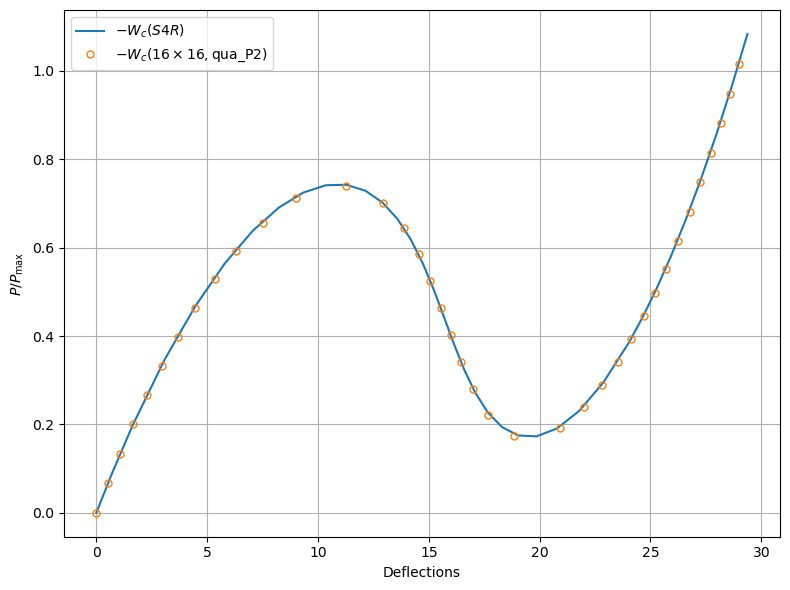

In [23]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    u3_list = u3_list[:i+1]
    Fc_list = Fc_list[:i+1]
    Fc_max = 750.0
    np.savetxt(results_folder/"u3_list.txt", u3_list)
    np.savetxt(results_folder/"Fc_list.txt", Fc_list)
    if thickness == 12.7:
        P_S4R = np.array([0.0000, 0.0877, 0.1980, 0.3473, 0.4686, 0.5647, 0.6381, 0.6908,
                        0.7246, 0.7412, 0.7421, 0.7286, 0.7023, 0.6649, 0.6182,
                        0.5643, 0.5055, 0.4442, 0.3830, 0.3245, 0.2717, 0.2272,
                        0.1940, 0.1750, 0.1729, 0.1905, 0.2303, 0.2950, 0.3871,
                        0.4443, 0.5093, 0.5826, 0.6644, 0.7551, 0.8549, 0.9643, 1.0835])
        
        Wc_S4R = np.array([0.0000, 0.6930, 1.6380, 3.0870, 4.4770, 5.8020, 7.0570, 8.2370, 
                        9.3390, 10.358, 11.293, 12.141, 12.903, 13.583, 14.188,
                        14.728, 15.217, 15.676, 16.125, 16.590, 17.094, 17.657,
                        18.299, 19.028, 19.852, 20.771, 21.780, 22.875, 24.049,
                        24.663, 25.293, 25.940, 26.601, 27.276, 27.964, 28.663, 29.374])
    elif thickness == 6.35:
        P_S4R = np.array([0.0000, 0.0517, 0.1182, 0.1583, 0.1837, 0.1914, 0.1953, 0.1950,
                        0.1901, 0.1806, 0.1671, 0.1323, 0.0923, 0.0504, 0.0083,
                        -0.0312, -0.0622, -0.0739, -0.0861, -0.1001, -0.1142, -0.1247,
                        -0.1288, -0.1271, -0.1196, -0.1055, -0.0825, -0.0484, -0.0006,
                        0.0626, 0.1427, 0.2403, 0.3559, 0.4898, 0.6417, 0.8114, 1.0313])
        
        Wc_S4R = np.array([0.0000, 1.8460, 5.2710, 8.2570, 10.799, 11.904, 12.892, 13.752, 
                        14.472, 15.050, 15.501, 16.145, 16.602, 16.915, 17.008,
                        16.697, 15.780, 15.206, 14.767, 14.520, 14.451, 14.862,
                        15.778, 16.961, 18.320, 19.817, 21.420, 23.100, 24.824,
                        26.565, 28.302, 30.023, 31.720, 33.388, 35.024, 36.626, 38.450])

    plt.figure(figsize=(8.0, 6.0))
    plt.plot(Wc_S4R, P_S4R, "-", label="$-W_c(S4R)$")
    plt.plot(-u3_list, -Fc_list / Fc_max, "o", markersize=5, markerfacecolor='none',
             markevery = 1, label=f"$-W_c({nex}\\times{ney},${ele_type})")
    plt.xlabel("Deflections")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")